### Note

This a Python implementation of [this](https://gallery.azure.ai/Notebook/Predictive-Maintenance-Implementation-Guide-R-Notebook-2) popular R notebook that contains the steps of implementing a predictive maintenance model.

# Problem Description

A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant costs that are associated with delays in the production process due to mechanical problems. Most of these businesses are interested in predicting these problems in advance so that they can proactively prevent the problems before they occur which will reduce the costly impact caused by downtime. Please refer to the [playbook for predictive maintenance](https://docs.microsoft.com/en-us/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance) for a detailed explanation of common use cases in predictive maintenance and modelling approaches.

In this notebook, we follow the ideas from the playbook referenced above and aim to provide the steps of implementing a predictive model for a scenario which is based on a synthesis of multiple real-world business problems. This example brings together common data elements observed among many predictive maintenance use cases and the data itself is created by data simulation methods.

The business problem for this example is about predicting problems caused by component failures such that the question “What is the probability that a machine will fail in the near future due to a failure of a certain component” can be answered. The problem is formatted as a multi-class classification problem and a machine learning algorithm is used to create the predictive model that learns from historical data collected from machines. In the following sections, we go through the steps of implementing such a model which are feature engineering, label construction, training and evaluation. First, we start by explaining the data sources in the next section.

# Data Sources

Common data sources for predictive maintenance problems are

+ Failure history: The failure history of a machine or component within the machine.
+ Maintenance history: The repair history of a machine, e.g. error codes, previous maintenance activities or component replacements.
+ Machine conditions and usage: The operating conditions of a machine e.g. data collected from sensors.
+ Machine features: The features of a machine, e.g. engine size, make and model, location.
+ Operator features: The features of the operator, e.g. gender, past experience

The data for this example comes from 4 different sources which are real-time telemetry data collected from machines, error messages, historical maintenance records that include failures and machine information such as type and age.

# Telemetry

The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected during the year 2015. Below, we provide first 10 records of the first machine with machineID=1. A summary of the whole dataset is also provided.

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [2]:
telemetry = pd.read_csv("../data/telemetry.csv")
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'],format="%m/%d/%Y %I:%M:%S %p")

print("Total Number of telemetry records: {}".format(str(len(telemetry))))
print("Dates range from {} to {}".format(str(telemetry["datetime"].min()),str(telemetry["datetime"].max())))

Total Number of telemetry records: 876100
Dates range from 2015-01-01 06:00:00 to 2016-01-01 06:00:00


In [3]:
telemetry.describe()

,machineID,volt,rotate,pressure,vibration
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007
std,28.866087,15.509114,52.673886,11.048679,5.370361
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,25.750000,160.304927,412.305714,93.498181,36.777299
50%,50.500000,170.607338,447.558150,100.425559,40.237247
75%,75.250000,181.004493,482.176600,107.555231,43.784938
max,100.000000,255.124717,695.020984,185.951998,76.791072


In [4]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


As an example, below is a plot of voltage values for two machineIDs for January 2015.

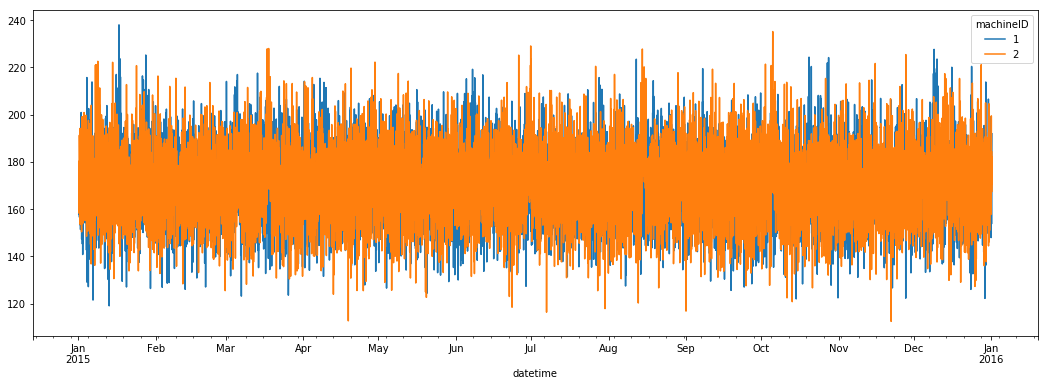

In [5]:
volt_sample = telemetry[telemetry["machineID"].isin([1,2])].pivot("datetime", 'machineID')["volt"]
volt_sample.plot(figsize=(18, 6)); 

# Errors

The second major data source is the error logs. These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [6]:
errors = pd.read_csv("../data/errors.csv")
errors['datetime'] = pd.to_datetime(errors['datetime'],format="%m/%d/%Y %I:%M:%S %p")

print("Total Number of error records: {}".format(str(len(errors))))

Total Number of error records: 3919


In [7]:
pd.concat([errors.head(5),errors.tail(5)])

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4
3914,2015-11-21 08:00:00,100,error2
3915,2015-12-04 02:00:00,100,error1
3916,2015-12-08 06:00:00,100,error2
3917,2015-12-08 06:00:00,100,error3
3918,2015-12-22 03:00:00,100,error3


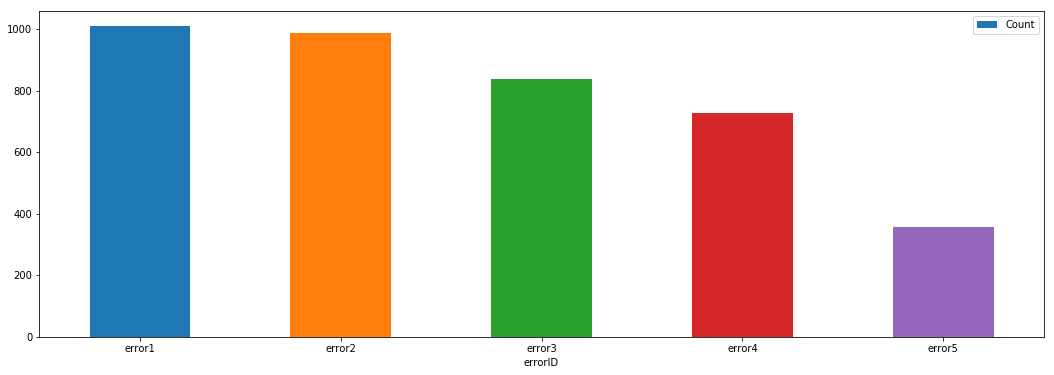

In [8]:
error_count = errors.groupby("errorID").count().reset_index().rename(index=str, columns={"machineID":"Count"})
error_count.plot.bar(x='errorID', y='Count',rot=0,figsize=(18, 6));

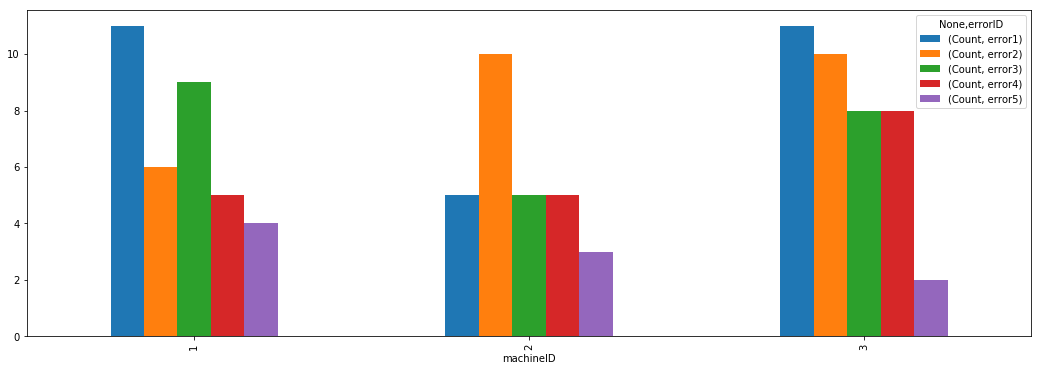

In [9]:
machine_error_count =errors[errors["machineID"].isin([1,2,3])].groupby(["machineID","errorID"]).count().rename(index=str, columns={"datetime":"Count"})
machine_error_count.unstack().plot.bar(figsize=(18, 6));

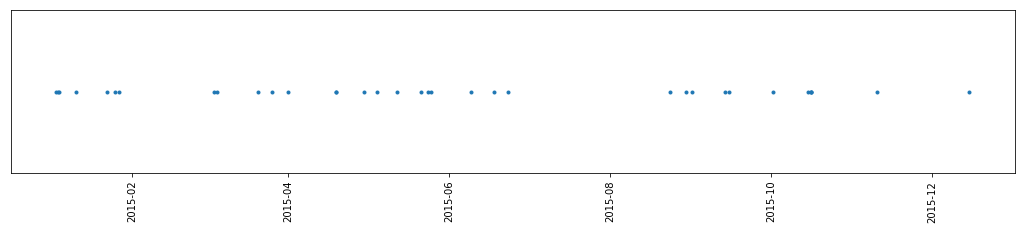

In [10]:
plt.figure(figsize=(18, 3))
plt.plot(errors[errors["machineID"].isin([1])]["datetime"], errors[errors["machineID"].isin([1])]["machineID"], '.')
plt.xticks(rotation='vertical')
plt.yticks([]);

# Maintenance

These are the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced during the scheduled inspection or replaced due to a break down. The records that are created due to break downs will be called failures which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

In [11]:
maint = pd.read_csv("../data/maint.csv")
maint['datetime'] = pd.to_datetime(maint['datetime'],format="%m/%d/%Y %I:%M:%S %p")

print("Total Number of maintenance records: {}".format(str(len(maint))))
print("Dates range from {} to {}".format(str(maint["datetime"].min()),str(maint["datetime"].max())))

Total Number of maintenance records: 3286
Dates range from 2014-06-01 06:00:00 to 2016-01-01 06:00:00


In [12]:
pd.concat([maint.head(5),maint.tail(5)])

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4
3281,2015-10-10 06:00:00,100,comp3
3282,2015-10-25 06:00:00,100,comp4
3283,2015-11-09 06:00:00,100,comp4
3284,2015-12-09 06:00:00,100,comp2
3285,2015-12-24 06:00:00,100,comp2


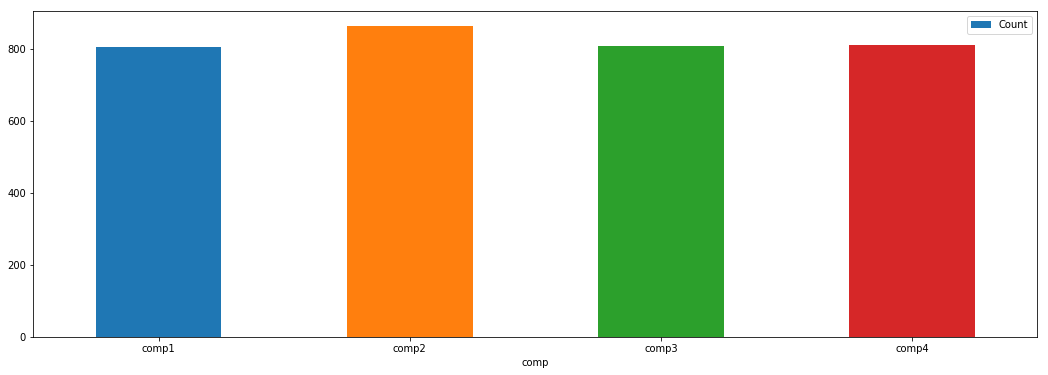

In [13]:
maint_count = maint.groupby("comp").count().reset_index().rename(index=str, columns={"machineID":"Count"})
maint_count.plot.bar(x='comp', y='Count',rot=0,figsize=(18, 6));

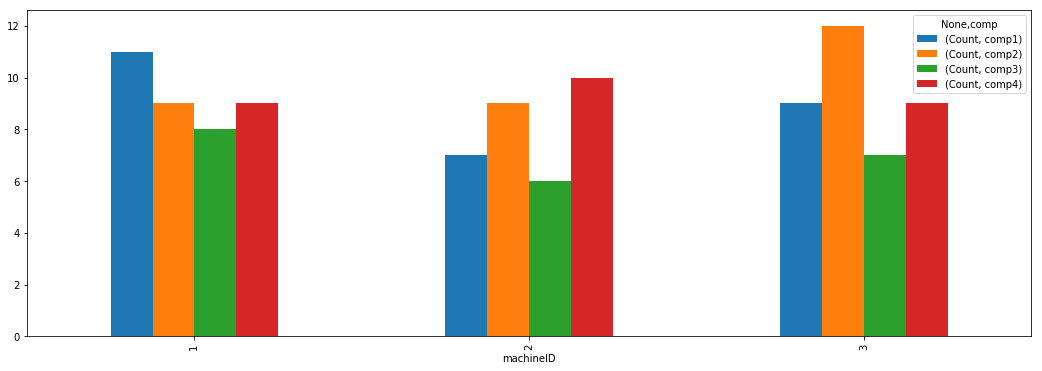

In [14]:
machine_maint_count =maint[maint["machineID"].isin([1,2,3])].groupby(["machineID","comp"]).count().rename(index=str, columns={"datetime":"Count"})
machine_maint_count.unstack().plot.bar(figsize=(18, 6));

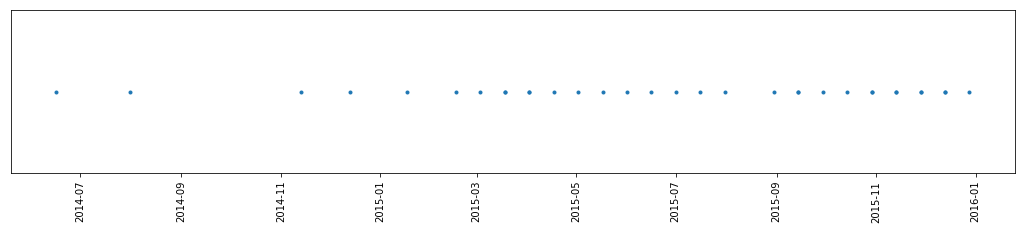

In [15]:
plt.figure(figsize=(18, 3))
plt.plot(maint[maint["machineID"].isin([4])]["datetime"], maint[maint["machineID"].isin([4])]["machineID"], '.')
plt.xticks(rotation='vertical')
plt.yticks([]);

# Machines

In [16]:
machines = pd.read_csv("../data/machines.csv")

print("Total Number of machines: {}".format(str(len(machines))))

Total Number of machines: 100


In [17]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


In [18]:
machines.describe()

,machineID,age
count,100.000000,100.000000
mean,50.500000,11.330000
std,29.011492,5.856974
min,1.000000,0.000000
25%,25.750000,6.750000
50%,50.500000,12.000000
75%,75.250000,16.000000
max,100.000000,20.000000


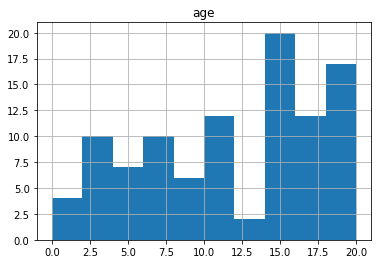

In [19]:
machines.hist(column = "age",bins=10);

# Failures

These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

In [20]:
failures = pd.read_csv("../data/failure.csv")
failures['datetime'] = pd.to_datetime(failures['datetime'],format="%m/%d/%Y %I:%M:%S %p")

print("Total Number of failures: {}".format(str(len(failures))))

Total Number of failures: 761


In [21]:
pd.concat([failures.head(5),failures.tail(5)])

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4
756,2015-11-29 06:00:00,99,comp3
757,2015-12-14 06:00:00,99,comp4
758,2015-02-12 06:00:00,100,comp1
759,2015-09-10 06:00:00,100,comp1
760,2015-12-09 06:00:00,100,comp2


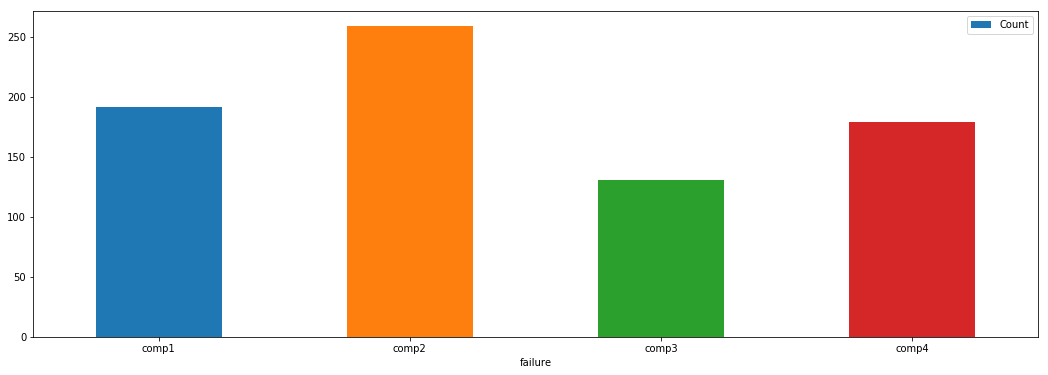

In [22]:
failures_count = failures.groupby("failure").count().reset_index().rename(index=str, columns={"machineID":"Count"})
failures_count.plot.bar(x='failure', y='Count',rot=0,figsize=(18, 6));

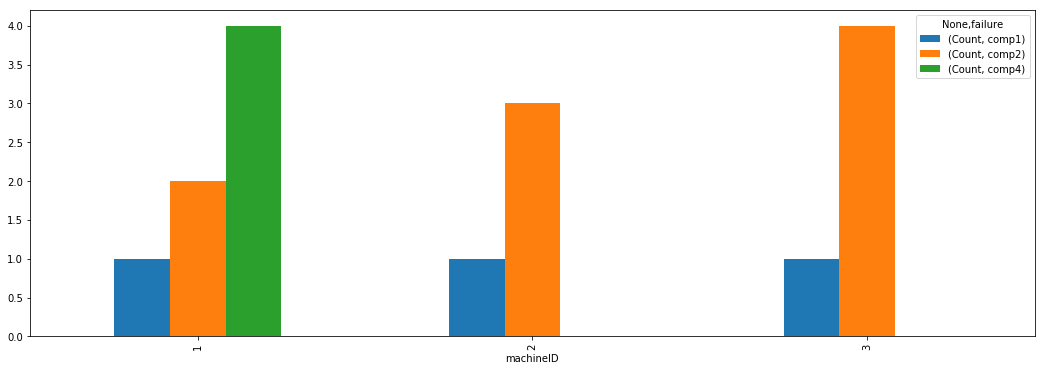

In [23]:
machine_failure_count =failures[failures["machineID"].isin([1,2,3])].groupby(["machineID","failure"]).count().rename(index=str, columns={"datetime":"Count"})
machine_failure_count.unstack().plot.bar(figsize=(18, 6));

# Feature Engineering

The first step in predictive maintenance applications is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, different type of feature engineering methods are used to create features based on the properties of each data source.

### Lag Features from Telemetry

Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In the following, rolling mean and standard deviation of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.

In [24]:
# calculate the rolling mean and rolling standard deviation 
# on the last 3 hour lag window (width=3), for every 3 hours (by=3)
# for each machine ID.
features = ["volt","rotate","pressure","vibration"]

telemetrymean = telemetry.set_index("datetime")\
    .groupby("machineID").rolling(window=3)\
    .mean()[features].reset_index().groupby("machineID").resample('3h', label='right',on = "datetime")\
    .first().drop(columns=["datetime","machineID"]).reset_index().rename(index=str,
                                                           columns={"volt":"voltmean","rotate":"rotatemean",
                                                                    "pressure":"pressuremean","vibration":"vibrationmean"})
telemetrymean.head()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,165.443986,425.415550,93.315664,39.571655
2,1,2015-01-01 15:00:00,162.223630,454.923953,106.523125,34.799816
3,1,2015-01-01 18:00:00,172.355243,423.041389,105.491224,40.288677
4,1,2015-01-01 21:00:00,160.226142,440.413573,95.424693,41.776012


In [25]:
telemetrysd = telemetry.set_index("datetime")\
    .groupby("machineID").rolling(window=3)\
    .std()[features].reset_index().groupby("machineID").resample('3h', label='right',on = "datetime")\
    .first().drop(columns=["datetime","machineID"]).reset_index().rename(index=str,
                                                           columns={"volt":"voltsd","rotate":"rotatesd",
                                                                    "pressure":"pressuresd","vibration":"vibrationsd"})
telemetrysd.head()

,machineID,datetime,voltsd,rotatesd,pressuresd,vibrationsd
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,4.807415,92.702671,17.106476,4.808836
2,1,2015-01-01 15:00:00,8.919370,38.316408,9.176711,8.414362
3,1,2015-01-01 18:00:00,3.056496,33.200513,4.843754,5.011355
4,1,2015-01-01 21:00:00,6.853823,54.501054,8.931082,2.889493


For caputing a longer term effect, 24 hour lag features are also calculated as below.

In [26]:
# calculate the rolling mean and rolling standard deviation 
# on the last 24 hour lag window (width=24), for every 3 hours (by=3)
# for each machine ID.
telemetrymean_24hrs = telemetry.set_index("datetime")\
    .groupby("machineID").rolling(window=24)\
    .mean()[features].reset_index().groupby("machineID").resample('3h', label='right',on = "datetime")\
    .first().drop(columns=["datetime","machineID"]).reset_index().dropna().rename(index=str,
                                                           columns={"volt":"voltmean_24hrs","rotate":"rotatemean_24hrs",
                                                                    "pressure":"pressuremean_24hrs","vibration":"vibrationmean_24hrs"})
telemetrymean_24hrs.head()

,machineID,datetime,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214


In [27]:
telemetrysd_24hrs = telemetry.set_index("datetime")\
    .groupby("machineID").rolling(window=24)\
    .std()[features].reset_index().groupby("machineID").resample('3h', label='right',on = "datetime")\
    .first().drop(columns=["datetime","machineID"]).reset_index().dropna().rename(index=str,
                                                           columns={"volt":"voltsd_24hrs","rotate":"rotatesd_24hrs",
                                                                    "pressure":"pressuresd_24hrs","vibration":"vibrationsd_24hrs"})
telemetrysd_24hrs.head()

,machineID,datetime,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs
7,1,2015-01-02 06:00:00,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,13.954518,43.490234,8.061653,5.898069


Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry.

In [28]:
telemetryfeat = telemetrymean.merge(telemetrysd,how = "left",on=["datetime","machineID"])
telemetryfeat_24hrs = telemetrymean_24hrs.merge(telemetrysd_24hrs,how = "left",on=["datetime","machineID"])
telemetryfeat = telemetryfeat.merge(telemetryfeat_24hrs,how = "left",on=["datetime","machineID"])
telemetryfeat = telemetryfeat.dropna()
telemetryfeat.head()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs
7,1,2015-01-02 06:00:00,165.002124,456.438211,87.673270,41.527048,5.959072,54.613403,7.623486,2.704438,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,193.164359,448.652619,101.438946,38.133459,10.459846,46.294659,11.281152,12.407322,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,159.676811,430.571937,100.242184,37.664039,11.972868,51.632304,12.041639,4.682870,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,173.019460,432.717201,98.126809,40.647784,12.377689,17.368725,7.650921,6.248584,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,168.747581,456.696379,98.297446,38.895426,14.479508,62.025493,4.085463,7.128157,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069


In [29]:
telemetryfeat.describe()

,machineID,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,voltmean_24hrs,rotatemean_24hrs,pressuremean_24hrs,vibrationmean_24hrs,voltsd_24hrs,rotatesd_24hrs,pressuresd_24hrs,vibrationsd_24hrs
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,170.772547,446.612226,100.855639,40.384550,13.303603,44.451821,8.882142,4.443792,170.773241,446.612525,100.855093,40.384618,14.918908,49.948358,10.046716,5.002063
std,28.86612,9.497656,33.121387,7.414014,3.473530,6.959158,23.231438,4.652707,2.321982,4.718257,18.075358,4.734948,2.059840,2.260736,7.682014,1.713750,0.799835
min,1.00000,132.337526,220.263189,75.117693,26.766911,0.020653,0.053928,0.011144,0.009530,155.812721,266.010419,91.057429,35.060087,6.380619,18.385248,4.145308,2.144863
25%,25.75000,164.427484,427.482086,96.223050,38.152366,8.042524,26.933229,5.369286,2.693907,168.070900,441.549418,98.668589,39.354137,13.358744,44.669810,8.924362,4.460346
50%,50.50000,170.412275,448.318376,100.232800,40.155826,12.499605,41.802913,8.336214,4.172612,170.211185,449.211690,100.097667,40.072808,14.853948,49.613807,9.921421,4.958585
75%,75.25000,176.621287,468.427326,104.411412,42.229070,17.667303,59.035242,11.801273,5.899550,172.460011,456.368100,101.611121,40.833388,16.394726,54.822037,10.980510,5.484489
max,100.00000,233.481896,590.642954,166.190047,66.916221,59.439210,194.598434,36.174137,19.166876,220.782618,499.096975,152.394833,61.932124,27.664538,103.819404,28.654103,12.325783


### Lag Features from Errors

Similar to telemetry, errors also come with time-stamps. However, unlike telemetry that had numerical values, errors have categorical values denoting the type of error that occured at a time-stamp. In this case, aggregating methods such as averaging does not apply. Counting the different categories is a more viable approach where lagging counts of different types of errors that occured in the lag window are calculated. Below we create such lagging counts from the errors received.

In [30]:
# create a column for each error type
errorcount = errors.copy()
errorcount = pd.concat([errorcount,pd.get_dummies(errorcount["errorID"])],axis=1).drop(columns=["errorID"])
errorcount.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-03 07:00:00,1,1,0,0,0,0
1,2015-01-03 20:00:00,1,0,0,1,0,0
2,2015-01-04 06:00:00,1,0,0,0,0,1
3,2015-01-10 15:00:00,1,0,0,0,1,0
4,2015-01-22 10:00:00,1,0,0,0,1,0


In [31]:
# sum the duplicate errors in an hour
errorcount = errorcount.groupby(['machineID','datetime']).sum().reset_index()
errorcount.head()

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1,0,0,0,0
1,1,2015-01-03 20:00:00,0,0,1,0,0
2,1,2015-01-04 06:00:00,0,0,0,0,1
3,1,2015-01-10 15:00:00,0,0,0,1,0
4,1,2015-01-22 10:00:00,0,0,0,1,0


In [32]:
# align errors with telemetry datetime field
errorfeat = telemetry.merge(errorcount,how="left")
# replace missing values
errorfeat = errorfeat.fillna(0)
errorfeat.head()

,datetime,machineID,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,0.0,0.0,0.0,0.0,0.0


In [33]:
errorfeat.describe()

,machineID,volt,rotate,pressure,vibration,error1,error2,error3,error4,error5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,170.777736,446.605119,100.858668,40.385007,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,15.509114,52.673886,11.048679,5.370361,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,160.304927,412.305714,93.498181,36.777299,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,170.607338,447.558150,100.425559,40.237247,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,181.004493,482.176600,107.555231,43.784938,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,255.124717,695.020984,185.951998,76.791072,1.000000,1.000000,1.000000,1.000000,1.000000


In [34]:
# count the number of errors of different types in the last 24 hours,  for every 3 hours
errorfeat = errorfeat.set_index("datetime")\
    .groupby("machineID").rolling(window=24)\
    .sum()[[x for x in list(errorfeat.columns) if "error" in x]]\
    .reset_index().groupby("machineID").resample('3h', label='right',on = "datetime")\
    .first().drop(columns=["datetime","machineID"]).reset_index().dropna()
errorfeat.columns = [x +"count" if "error" in x else x  for x in errorfeat.columns]
errorfeat.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


In [35]:
errorfeat.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,291400.00000,291400.000000,291400.000000,291400.000000,291400.000000,291400.000000
mean,50.50000,0.027649,0.027069,0.022907,0.019904,0.009753
std,28.86612,0.166273,0.164429,0.151453,0.140820,0.098797
min,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.75000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.50000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.25000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.00000,2.000000,2.000000,2.000000,2.000000,2.000000


### Days Since Last Replacement from Maintenance

A crucial data set in this example is the maintenance records which contain the information of component replacement records. Possible features from this data set can be, for example, the number of replacements of each component in the last 3 months to incorporate the frequency of replacements. However, more relevent information would be to calculate how long it has been since a component is last replaced as that would be expected to correlate better with component failures since the longer a component is used, the more degradation should be expected.

As a side note, creating lagging features from maintenance data is not as sensible as it is for telemetry and errors so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. In the following, the days since last component replacement are calculated for each component type as features from the maintenance data.

In [36]:
comprep = maint.copy()
comprep = comprep.sort_values(["datetime","machineID"])
comprep["datetime_comp"] = comprep["datetime"]

compdate = telemetryfeat[["datetime","machineID"]].sort_values(["datetime","machineID"])

In [37]:
compdate_res = []
for group in comprep.groupby("comp"):
    compdate_res.append(pd.merge_asof(compdate, group[1].sort_values(["datetime","machineID"]),on='datetime', by='machineID'))
compdate_res = pd.concat(compdate_res)
compdate_res['date_diff'] = (compdate_res.datetime-compdate_res.datetime_comp).astype('timedelta64[m]')/(60*24)
compdate_res = compdate_res.drop(columns=["datetime_comp"])

In [38]:
compdate_res = pd.pivot_table(compdate_res,columns="comp",index=["datetime","machineID"],values="date_diff")
compdate_res.columns.name = None
compfeat = compdate_res.reset_index()

compfeat.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-02 06:00:00,1,20.0,215.0,155.0,170.0
1,2015-01-02 06:00:00,2,200.0,140.0,170.0,35.0
2,2015-01-02 06:00:00,3,140.0,35.0,200.0,185.0
3,2015-01-02 06:00:00,4,155.0,200.0,50.0,20.0
4,2015-01-02 06:00:00,5,80.0,125.0,140.0,95.0


### Machine Features

The machine features are used directly as they are since they hold descriptive information about the type of the machines and their ages which is the years in service. If the years in service information has been received in the form of dates denoting the date of first service then a transformation would have been necessary to turn those into a numeric values indicating the years in service.

Lastly, we merge all the feature data sets we created earlier to get the final feature matrix.

In [39]:
# telemetry and error features have the same datetime 
finalfeat = telemetryfeat\
            .merge(errorfeat,how = "left", on = ["datetime","machineID"])\
            .merge(compfeat,how = "left", on = ["datetime","machineID"])\
            .merge(machines,how = "left", on = ["machineID"])
print(("The final set of features are: {}".format(", ".join(finalfeat.columns))))

The final set of features are: machineID, datetime, voltmean, rotatemean, pressuremean, vibrationmean, voltsd, rotatesd, pressuresd, vibrationsd, voltmean_24hrs, rotatemean_24hrs, pressuremean_24hrs, vibrationmean_24hrs, voltsd_24hrs, rotatesd_24hrs, pressuresd_24hrs, vibrationsd_24hrs, error1count, error2count, error3count, error4count, error5count, comp1, comp2, comp3, comp4, model, age


In [40]:
finalfeat.head()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age
0,1,2015-01-02 06:00:00,165.002124,456.438211,87.673270,41.527048,5.959072,54.613403,7.623486,2.704438,...,0.0,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18
1,1,2015-01-02 09:00:00,193.164359,448.652619,101.438946,38.133459,10.459846,46.294659,11.281152,12.407322,...,0.0,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18
2,1,2015-01-02 12:00:00,159.676811,430.571937,100.242184,37.664039,11.972868,51.632304,12.041639,4.682870,...,0.0,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18
3,1,2015-01-02 15:00:00,173.019460,432.717201,98.126809,40.647784,12.377689,17.368725,7.650921,6.248584,...,0.0,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18
4,1,2015-01-02 18:00:00,168.747581,456.696379,98.297446,38.895426,14.479508,62.025493,4.085463,7.128157,...,0.0,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18


### Label Construction

When using multi-class classification for predicting failure due to a problem, labeling is done by taking a time window prior to the failure of an asset and labeling the feature records that fall into that window as “about to fail due to a problem” while labeling all other records as “normal”. This time window should be picked according to the business case where in some situations it may be enough to predict failures hours in advance while in others days or weeks maybe needed to allow for the arrival of parts to be replaced as an example.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1,2,3 or 4). In the following, labelling is done by labeling all the feature records that fall into the 24 hours window before a failure due to component 1, component 2, component 3 and component 4 as comp1, comp2, comp3 and comp4 respectively.The rest of the records are labeled as "none" indicating, there is no failure within the next 24 hours.

In [50]:
labeled = finalfeat.merge(failures,on="machineID",how="left",suffixes = (".x",".y"))
labeled["hours"] = (labeled["datetime"]-labeled["datetime.x"]).astype('timedelta64[m]')/(60*24)
labeled = labeled[(labeled["hours"]>=0) & (labeled["hours"]<=24)]

labeledfeatures = finalfeat.merge(labeled[["datetime","machineID","failure"]],
                                  left_on = ["datetime","machineID"],
                                  right_on = ["datetime","machineID"],how="left").sort_values(["machineID","datetime"])
labeledfeatures["failure"] = labeledfeatures["failure"].fillna("none")


labeledfeatures.head()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
0,1,2015-01-02 06:00:00,165.002124,456.438211,87.673270,41.527048,5.959072,54.613403,7.623486,2.704438,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,none
1,1,2015-01-02 09:00:00,193.164359,448.652619,101.438946,38.133459,10.459846,46.294659,11.281152,12.407322,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,none
2,1,2015-01-02 12:00:00,159.676811,430.571937,100.242184,37.664039,11.972868,51.632304,12.041639,4.682870,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,none
3,1,2015-01-02 15:00:00,173.019460,432.717201,98.126809,40.647784,12.377689,17.368725,7.650921,6.248584,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,none
4,1,2015-01-02 18:00:00,168.747581,456.696379,98.297446,38.895426,14.479508,62.025493,4.085463,7.128157,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,none


Below is an example of records that are labeled as "comp4" in the failure column. First 8 records that fall into the same 24 hours are all labeled as a block. Next 8 records that are within 24 hours of another component 4 failure are also labeled as "comp4" as a block.

In [51]:
labeledfeatures[labeledfeatures.failure == "comp4"].head(16)

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
24,1,2015-01-05 06:00:00,154.212046,440.540882,97.872037,51.655132,25.308256,18.420666,4.506415,5.890503,...,0.0,0.0,1.0,0.000,218.000,158.000,0.000,model3,18,comp4
25,1,2015-01-05 09:00:00,186.444687,452.190194,102.339221,52.387565,13.950879,58.409426,8.720364,7.187453,...,0.0,0.0,0.0,0.125,218.125,158.125,0.125,model3,18,comp4
26,1,2015-01-05 12:00:00,155.592570,447.290787,112.555958,37.001792,16.806839,53.252836,12.308778,3.288541,...,0.0,0.0,0.0,0.250,218.250,158.250,0.250,model3,18,comp4
27,1,2015-01-05 15:00:00,176.837548,443.884916,107.854192,43.584355,3.853372,46.571597,9.673657,7.440204,...,0.0,0.0,0.0,0.375,218.375,158.375,0.375,model3,18,comp4
28,1,2015-01-05 18:00:00,178.864385,467.107236,106.942639,36.814172,3.655479,95.254520,4.759486,3.222387,...,0.0,0.0,0.0,0.500,218.500,158.500,0.500,model3,18,comp4
29,1,2015-01-05 21:00:00,184.937452,451.992807,85.109560,37.923651,13.657651,16.011818,5.928272,3.910569,...,0.0,0.0,0.0,0.625,218.625,158.625,0.625,model3,18,comp4
30,1,2015-01-06 00:00:00,164.516868,497.769429,110.460406,38.319823,11.502633,28.539120,1.932674,4.459396,...,0.0,0.0,0.0,0.750,218.750,158.750,0.750,model3,18,comp4
31,1,2015-01-06 03:00:00,167.353302,469.334090,104.412984,44.800895,23.461171,23.740252,10.382727,3.485921,...,0.0,0.0,0.0,0.875,218.875,158.875,0.875,model3,18,comp4
32,1,2015-01-06 06:00:00,168.320604,494.256088,103.248284,36.144221,7.728489,19.924480,11.946269,5.326222,...,0.0,0.0,0.0,1.000,219.000,159.000,1.000,model3,18,comp4
33,1,2015-01-06 09:00:00,176.099935,454.526293,99.090911,40.606321,9.453456,14.947651,8.239287,2.383222,...,0.0,0.0,0.0,1.125,219.125,159.125,1.125,model3,18,comp4


# Modelling

### Training, Validation and Testing

When working with data that comes with time-stamps such as telemetry and errors as in this example, splitting of data into training, validation and test sets should be performed carefully to prevent overestimating the performance of the models. In predictive maintenance, the features are usually generated using laging aggregates and consecutive examples that fall into the same time window may have similar feature values in that window. If a random splitting of training and testing is used, it is possible for some portion of these similar examples that are in the same window to be selected for training and the other portion to leak into the testing data. Also, it is possible for training examples to be ahead of time than validation and testing examples when data is randomly split. However, predictive models should be trained on historical data and valiadted and tested on future data. Due to these problems, validation and testing based on random sampling may provide overly optimistic results. Since random sampling is not a viable approach here, cross validation methods that rely on random samples such as k-fold cross validation is not useful either.

For predictive maintenance problems, a time-dependent spliting strategy is often a better approach to estimate performance which is done by validating and testing on examples that are later in time than the training examples. For a time-dependent split, a point in time is picked and model is trained on examples up to that point in time, and validated on the examples after that point assuming that the future data after the splitting point is not known. However, this effects the labelling of features falling into the labelling window right before the split as it is assumed that failure information is not known beyond the splitting cut-off. Due to that, those feature records can not be labeled and will not be used. This also prevents the leaking problem at the splitting point.

Validation can be performed by picking different split points and examining the performance of the models trained on different time splits. In the following, we use 3 different splitting points to train the model and look at the performances for different splits in the evaluation section.

In [53]:
# split at 2015-08-01 01:00:00, to train on the first 8 months and test on last 4 months
# labelling window is 24 hours so records within 24 hours prior to split point are left out

trainingdata1 = labeledfeatures[labeledfeatures.datetime < "2015-07-31 01:00:00"] 
testingdata1 = labeledfeatures[labeledfeatures.datetime > "2015-08-01 01:00:00"]

trainingdata1.tail()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
311452,100,2015-07-30 12:00:00,172.069024,449.869101,87.067886,39.388608,8.406144,39.451425,4.347532,6.545811,...,0.0,0.0,0.0,3.250,3.250,18.250,63.250,model4,5,none
311453,100,2015-07-30 15:00:00,177.009425,432.280265,96.461094,41.837893,12.165544,27.933018,7.161887,3.160531,...,0.0,0.0,0.0,3.375,3.375,18.375,63.375,model4,5,none
311454,100,2015-07-30 18:00:00,177.337394,438.548603,95.685153,35.628636,8.057822,66.610965,9.552550,4.053145,...,0.0,0.0,0.0,3.500,3.500,18.500,63.500,model4,5,none
311455,100,2015-07-30 21:00:00,170.274862,426.130999,99.659071,44.378116,6.620716,36.643861,11.739511,1.254475,...,0.0,0.0,0.0,3.625,3.625,18.625,63.625,model4,5,none
311456,100,2015-07-31 00:00:00,182.591983,465.583306,92.328436,36.117427,24.522167,35.085830,8.411513,4.369325,...,0.0,0.0,0.0,3.750,3.750,18.750,63.750,model4,5,none


In [54]:
testingdata1.head()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
1687,1,2015-08-01 03:00:00,156.385794,401.295016,108.776455,38.558874,12.139907,6.984688,2.023385,10.351387,...,0.0,0.0,0.0,12.875,27.875,57.875,42.875,model3,18,none
1688,1,2015-08-01 06:00:00,171.516240,461.278062,98.010894,37.003058,11.328060,47.479705,6.563849,7.262523,...,0.0,0.0,0.0,13.000,28.000,58.000,43.000,model3,18,none
1689,1,2015-08-01 09:00:00,165.578966,445.234573,91.977859,38.677758,18.727136,66.288499,5.388638,3.422065,...,0.0,0.0,0.0,13.125,28.125,58.125,43.125,model3,18,none
1690,1,2015-08-01 12:00:00,163.548113,468.906897,99.170409,36.019751,7.037640,42.826496,16.126765,2.201160,...,0.0,0.0,0.0,13.250,28.250,58.250,43.250,model3,18,none
1691,1,2015-08-01 15:00:00,176.207408,469.436110,93.108156,38.429382,15.862637,60.454819,4.685175,4.556225,...,0.0,0.0,0.0,13.375,28.375,58.375,43.375,model3,18,none


In [55]:
# split at 2015-09-01 01:00:00, to train on the first 9 months and test on last 3 months
# labelling window is 24 hours so records within 24 hours prior to split point are left out

trainingdata2 = labeledfeatures[labeledfeatures.datetime < "2015-08-31 01:00:00"] 
testingdata2 = labeledfeatures[labeledfeatures.datetime > "2015-09-01 01:00:00"]

trainingdata2.tail()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
311700,100,2015-08-30 12:00:00,167.820189,422.149997,105.181834,42.343005,10.289203,16.178193,19.957232,4.402042,...,0.0,0.0,0.0,34.250,34.250,19.250,4.250,model4,5,none
311701,100,2015-08-30 15:00:00,166.036296,464.557753,95.519580,36.737215,10.111289,35.805286,14.258345,4.652330,...,0.0,0.0,0.0,34.375,34.375,19.375,4.375,model4,5,none
311702,100,2015-08-30 18:00:00,180.981216,443.625395,100.915801,38.445595,2.193015,11.387467,4.413574,0.812510,...,0.0,1.0,0.0,34.500,34.500,19.500,4.500,model4,5,none
311703,100,2015-08-30 21:00:00,154.153460,426.027713,95.689561,41.389050,11.478071,25.249934,6.916943,5.183405,...,0.0,1.0,0.0,34.625,34.625,19.625,4.625,model4,5,none
311704,100,2015-08-31 00:00:00,169.484306,451.060180,104.250253,36.052450,10.357954,79.569066,4.318301,4.508852,...,0.0,1.0,0.0,34.750,34.750,19.750,4.750,model4,5,none


In [56]:
testingdata2.head()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
1935,1,2015-09-01 03:00:00,165.635103,470.020253,103.032238,49.711320,3.356698,73.358545,13.815566,7.024094,...,0.0,0.0,0.0,28.875,58.875,88.875,73.875,model3,18,none
1936,1,2015-09-01 06:00:00,167.822623,441.292846,103.251945,51.922345,13.463991,39.603979,5.658658,3.073315,...,0.0,0.0,0.0,29.000,59.000,89.000,74.000,model3,18,none
1937,1,2015-09-01 09:00:00,175.689854,420.639977,107.314018,45.462356,18.092930,10.981427,13.357122,0.647726,...,0.0,0.0,1.0,29.125,59.125,89.125,74.125,model3,18,none
1938,1,2015-09-01 12:00:00,172.622696,411.743832,85.330960,46.383486,9.625270,58.023275,8.767524,5.005484,...,0.0,0.0,1.0,29.250,59.250,89.250,74.250,model3,18,none
1939,1,2015-09-01 15:00:00,156.326227,485.739589,92.523040,54.463016,17.631652,4.798164,4.926777,5.456197,...,0.0,0.0,1.0,29.375,59.375,89.375,74.375,model3,18,none


In [57]:
# split at 2015-10-01 01:00:00, to train on the first 10 months and test on last 2 months
# labelling window is 24 hours so records within 24 hours prior to split point are left out

trainingdata3 = labeledfeatures[labeledfeatures.datetime < "2015-09-30 01:00:00"] 
testingdata3 = labeledfeatures[labeledfeatures.datetime > "2015-10-01 01:00:00"]

trainingdata3.tail()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
311940,100,2015-09-29 12:00:00,167.967209,412.971303,102.742147,42.135218,6.430297,6.258819,8.546507,3.574633,...,0.0,0.0,0.0,4.250,64.250,49.250,34.250,model4,5,comp1
311941,100,2015-09-29 15:00:00,162.701175,442.867753,98.761939,43.564404,34.695574,38.938293,5.893845,7.381405,...,0.0,0.0,0.0,4.375,64.375,49.375,34.375,model4,5,comp1
311942,100,2015-09-29 18:00:00,179.395190,461.527553,91.882379,42.100660,15.328637,73.010389,9.353277,2.664487,...,0.0,0.0,0.0,4.500,64.500,49.500,34.500,model4,5,comp1
311943,100,2015-09-29 21:00:00,153.707547,460.430058,102.493393,36.913340,10.951244,59.920104,8.006166,3.637233,...,0.0,0.0,0.0,4.625,64.625,49.625,34.625,model4,5,comp1
311944,100,2015-09-30 00:00:00,169.930556,430.777501,109.897938,43.699754,11.287831,63.836789,3.872588,5.271830,...,0.0,0.0,0.0,4.750,64.750,49.750,34.750,model4,5,comp1


In [58]:
testingdata3.head()

,machineID,datetime,voltmean,rotatemean,pressuremean,vibrationmean,voltsd,rotatesd,pressuresd,vibrationsd,...,error3count,error4count,error5count,comp1,comp2,comp3,comp4,model,age,failure
2175,1,2015-10-01 03:00:00,169.245540,442.627637,104.462725,38.321592,10.173033,13.039314,12.065268,3.138467,...,0.0,0.0,0.0,28.875,13.875,118.875,28.875,model3,18,none
2176,1,2015-10-01 06:00:00,167.426730,436.071694,106.367698,41.070711,7.671052,62.701574,18.335703,1.997812,...,0.0,0.0,0.0,29.000,14.000,119.000,29.000,model3,18,none
2177,1,2015-10-01 09:00:00,165.963823,437.685739,100.864636,35.683200,11.329255,23.056457,18.162806,12.575544,...,0.0,0.0,0.0,29.125,14.125,119.125,29.125,model3,18,none
2178,1,2015-10-01 12:00:00,183.989372,506.929201,100.554508,36.433078,8.993457,38.310057,9.588982,6.559752,...,0.0,0.0,0.0,29.250,14.250,119.250,29.250,model3,18,none
2179,1,2015-10-01 15:00:00,175.911389,441.858307,103.471122,42.071029,17.511583,78.282532,9.356221,1.695991,...,0.0,0.0,0.0,29.375,14.375,119.375,29.375,model3,18,none


In [74]:
x_train_1, y_train_1 = pd.get_dummies(trainingdata1.drop(columns=["failure","datetime"])), trainingdata1["failure"]
x_test_1, y_test_1 = pd.get_dummies(testingdata1.drop(columns=["failure","datetime"])), testingdata1["failure"]

x_train_2, y_train_2 = pd.get_dummies(trainingdata2.drop(columns=["failure","datetime"])), trainingdata2["failure"]
x_test_2, y_test_2 = pd.get_dummies(testingdata2.drop(columns=["failure","datetime"])), testingdata2["failure"]

x_train_3, y_train_3 = pd.get_dummies(trainingdata3.drop(columns=["failure","datetime"])), trainingdata3["failure"]
x_test_3, y_test_3 = pd.get_dummies(testingdata3.drop(columns=["failure","datetime"])), testingdata3["failure"]

In [80]:
import h2o

ModuleNotFoundError: No module named 'h2o'

In [75]:
# import machine learning algorithms
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [76]:
gbm_model1 = GradientBoostingClassifier(n_estimators = 50, max_depth = 5, learning_rate=0.1)
gbm_model2 = GradientBoostingClassifier(n_estimators = 50, max_depth = 5, learning_rate=0.1)
gbm_model3 = GradientBoostingClassifier(n_estimators = 50, max_depth = 5, learning_rate=0.1)

In [77]:
np.random.seed(1234)

gbm_model1.fit(x_train_1, y_train_1)
print("Learning rate: ", learning_rate)
print("Accuracy score (training): {0:.3f}".format(gbm_model1.score(x_train_1, y_train_1)))
print("Accuracy score (validation): {0:.3f}".format(gbm_model1.score(x_test_1, y_test_1)))
print()

KeyboardInterrupt: 